# Setup

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")
import copy
import pathlib
import warnings

import numpy as np
import pandas as pd
from prophet import Prophet, serialize

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import plotly.graph_objs as go

In [2]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"
saved_model_dir = root_dir / "models"
secret_dir = root_dir / "secrets"

In [3]:
raw_data = pd.read_csv(processed_data_dir / "klhk_usable_linearimputed_coord.csv")

# Data Processing

In [4]:
col_remap = {
    'klhk_usable_linearimputed_csv_stasiun':'stasiun',
    'klhk_usable_linearimputed_csv_lin_pm25':'pm25',
    'klhk_usable_linearimputed_csv_read_time':'read_time',
    'XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Latitude':'longitude',
    'XYDAFTAR_LOKASI_AQMS_JABODETABEK_2_Longitude':'latitude'
    }

# rename columns and use only important columns
processed_data = raw_data[col_remap.keys()].rename(columns=col_remap).drop(columns=['longitude','latitude'])

# drop some data from a stasiun
to_drop = np.arange(9201,processed_data[processed_data['stasiun'] == 'Depok Pancoran Mas'].index.max()+1)
processed_data = processed_data.drop(to_drop)

# convert to datetime
processed_data['read_time'] = pd.to_datetime(processed_data['read_time'], format="%d/%m/%Y %H:%M:%S")

In [5]:
# Define the proportions for train, validation, and test sets
train_frac = 0.8  # 60% of the data for training
test_frac = 0.2   # 20% for testing

# X_train, X_test, y_train, y_test = train_test_split(
#     processed_data,
#     processed_data_y,
#     test_size=test_frac,
#     # stratify=processed_data['stasiun'],
#     random_state=RANDOM_STATE, shuffle=False)

stasiun_counts = processed_data['stasiun'].value_counts()

# Initialize empty DataFrames for training and testing sets.
train_df_list = []
test_df_list = []

# Iterate through unique 'stasiun' values and split data proportionally.
for stasiun, count in stasiun_counts.items():
    stasiun_data_train = processed_data[processed_data['stasiun'] == stasiun]
    train_df, test_df = train_test_split(stasiun_data_train, test_size=int(count * test_frac), random_state=42, shuffle=False)

    # Append the split data to the respective DataFrames.
    train_df_list.append(train_df)
    test_df_list.append(test_df)
    # train_df = train_df.concat(train_data).sort_index()
    # test_df = test_df.concat(test_data).sort_index()

train_df = pd.concat(train_df_list)
test_df = pd.concat(test_df_list)

In [6]:
with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
    display(train_df)

,stasiun,pm25,read_time
0,Bekasi Kayuringin,96.0,2023-06-01 00:00:00
...,...,...,...
8743,Depok Pancoran Mas,51.0,2023-08-16 07:00:00


In [7]:
def isolate_stasiun(
    df:pd.DataFrame,
    used_stasiun:str,
    time_col:str='read_time',
    y_col:str='pm25'
    ):
    stasiun_data = df[df['stasiun'] == used_stasiun]
    stasiun_data = (
        stasiun_data[[time_col, y_col]]
        .rename(columns={
            time_col:'ds',
            y_col:'y'
        })
        )
    return stasiun_data

In [8]:
used_stasiun = 'Bekasi Kayuringin'
kayuringin_data_train = isolate_stasiun(train_df, used_stasiun)
kayuringin_data_test = isolate_stasiun(test_df, used_stasiun)

# Training pipeline

In [9]:
# setup baseline model
prophet_baseline = Prophet()
prophet_baseline.add_country_holidays(country_name='ID')

In [10]:
# train baseline model
prophet_baseline.fit(kayuringin_data_train)

11:30:51 - cmdstanpy - INFO - Chain [1] start processing
11:30:51 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# inferencing using baseline model
kayuringin_forecast = prophet_baseline.predict(kayuringin_data_test.drop(columns=['y']))
with pd.option_context('display.max_rows', 2, 'display.max_columns', None): 
    display(kayuringin_forecast)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascension Day,Ascension Day_lower,Ascension Day_upper,Buddha's Birthday,Buddha's Birthday_lower,Buddha's Birthday_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Day of Silence,Day of Silence_lower,Day of Silence_upper,Eid al-Adha,Eid al-Adha_lower,Eid al-Adha_upper,Eid al-Fitr,Eid al-Fitr_lower,Eid al-Fitr_upper,Eid al-Fitr Second Day,Eid al-Fitr Second Day_lower,Eid al-Fitr Second Day_upper,Good Friday,Good Friday_lower,Good Friday_upper,Independence Day,Independence Day_lower,Independence Day_upper,International Labor Day,International Labor Day_lower,International Labor Day_upper,Islamic New Year,Islamic New Year_lower,Islamic New Year_upper,Lunar New Year,Lunar New Year_lower,Lunar New Year_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Pancasila Day,Pancasila Day_lower,Pancasila Day_upper,The Prophet's Ascension,The Prophet's Ascension_lower,The Prophet's Ascension_upper,The Prophet's Birthday* (*estimated),The Prophet's Birthday* (*estimated)_lower,The Prophet's Birthday* (*estimated)_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-08-16 20:00:00,88.833989,76.945958,107.275321,88.833989,88.833989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.589912,3.589912,3.589912,-0.079580,-0.079580,-0.079580,0.0,0.0,0.0,3.669491,3.669491,3.669491,0.0,0.0,0.0,92.423901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,2023-09-04 23:00:00,84.057963,63.944380,95.483207,82.289548,85.830899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.531533,-4.531533,-4.531533,-0.084019,-0.084019,-0.084019,0.0,0.0,0.0,-4.447515,-4.447515,-4.447515,0.0,0.0,0.0,79.526430


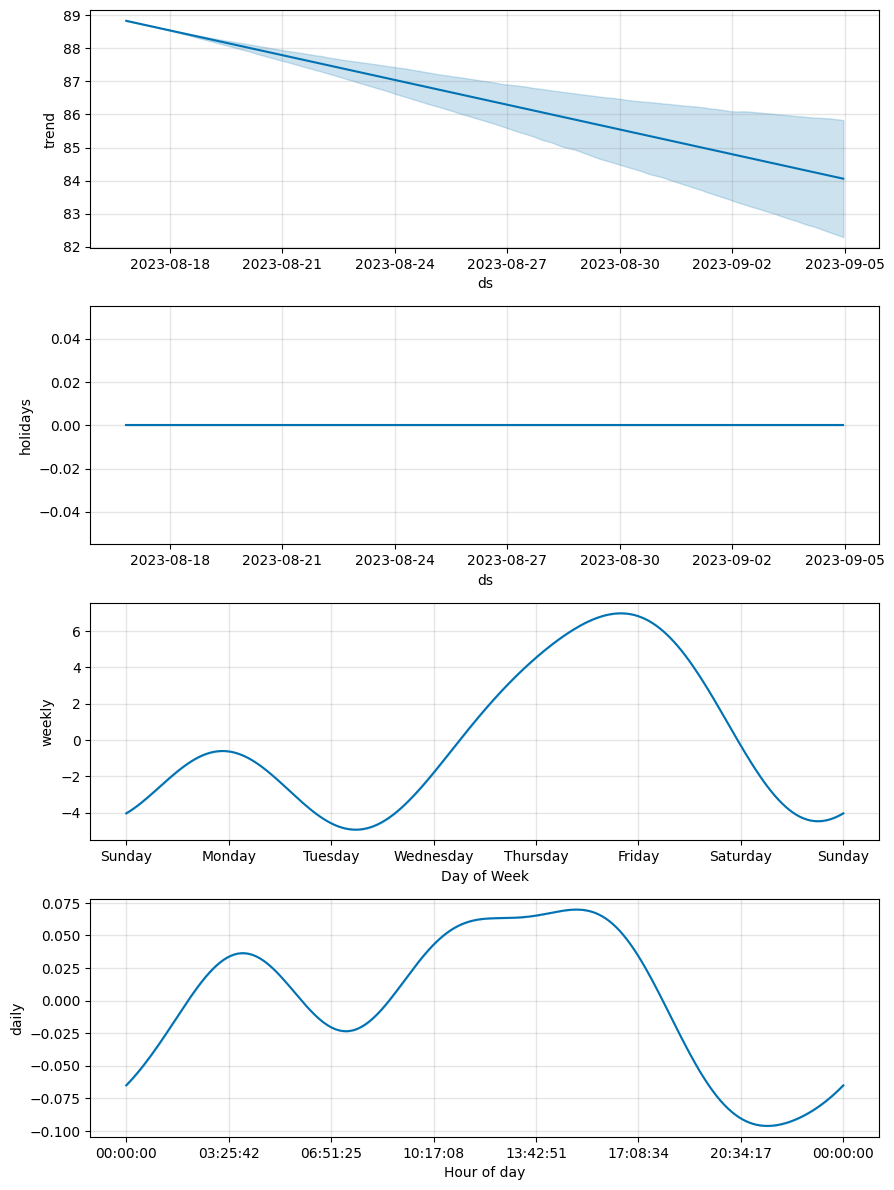

In [12]:
fig = prophet_baseline.plot_components(kayuringin_forecast)

In [48]:
import matplotlib.pyplot as plt

In [66]:
def plot_test(
    stasiun_name:str,
    train_df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    test_df: pd.DataFrame
):
    # Create a Matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training data, true prediction value, and predicted value
    ax.plot(train_df['ds'], train_df['y'], label='Training Data')
    ax.plot(test_df['ds'], test_df['y'], label='True Prediction Value')
    ax.plot(forecast_df['ds'], forecast_df['yhat'], label='Predicted Value')

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_df['y'], forecast_df['yhat']))

    # Add title and labels
    ax.set_title(f'{stasiun_name} Training Data vs. True Prediction vs. Predicted Value')
    ax.set_xlabel('Datetime')
    ax.set_ylabel('PM 2.5 Index')

    # Add RMSE as a subtitle
    ax.annotate(f'RMSE: {rmse:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                fontsize=12, color='red')

    # Add legend
    ax.legend()

    return fig, rmse

In [47]:
def plotly_plot_test(
    train_df:pd.DataFrame,
    forecast_df:pd.DataFrame,
    test_df:pd.DataFrame
):
    # Create traces for training data, true prediction value, and predicted value
    trace_train = go.Scatter(x=train_df['ds'], y=train_df['y'], mode='lines', name='Training Data')
    trace_true_pred = go.Scatter(x=test_df['ds'], y=test_df['y'], mode='lines', name='True Prediction Value')
    trace_pred = go.Scatter(x=forecast_df['ds'], y=forecast_df['yhat'], mode='lines', name='Predicted Value')

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_df['y'], forecast_df['yhat']))

    # Create layout for the plot with RMSE as subtitle
    layout = go.Layout(title='Training Data vs. True Prediction vs. Predicted Value',
                    xaxis=dict(title='Datetime'),
                    yaxis=dict(title='Value'),
                    annotations=[dict(xref='paper', yref='paper', x=0, y=1.1,
                                        text=f'RMSE: {rmse:.4f}', showarrow=False,
                                        font=dict(color='red'))])

    # Create a figure and add the traces
    fig = go.Figure(data=[trace_train, trace_true_pred, trace_pred], layout=layout)
    
    return fig, rmse

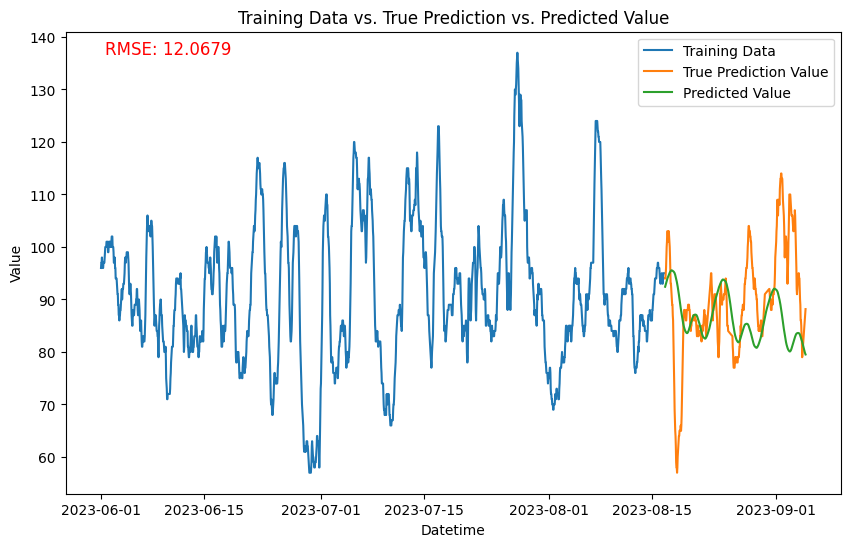

In [50]:
fig, rmse = plot_test(
    train_df=kayuringin_data_train,
    forecast_df=kayuringin_forecast,
    test_df=kayuringin_data_test
)
fig.show()

# Cross Validation

In [14]:
from prophet.diagnostics import cross_validation
horizon=24*3
df_cv = cross_validation(
    prophet_baseline,
    # initial=f'{horizon*3} hours',
    # period=f'{12} hours',
    horizon=f'{horizon} hours',
    parallel="processes"
    )

In [15]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [30]:
metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
# cv_metrics = performance_metrics(metrics_raw)
metrics = {k: df_p[k].mean() for k in metric_keys}

In [31]:
metrics

{'mse': 373.35599428629473,
 'rmse': 19.27618627011709,
 'mae': 15.371884051535009,
 'mape': 0.17761751755659053,
 'mdape': 0.13456327092874518,
 'smape': 0.17158542019021034,
 'coverage': 0.5004248915641321}

In [16]:
# Sort the DataFrame by RMSE in ascending order
sorted_df = df_p.sort_values(by='rmse', ascending=True)

# Get the row with the lowest RMSE value (i.e., the best horizon)
best_horizon_row = sorted_df.iloc[0]

# Extract the best horizon from the row
best_horizon = best_horizon_row['horizon']
best_horizon

Timedelta('0 days 08:00:00')

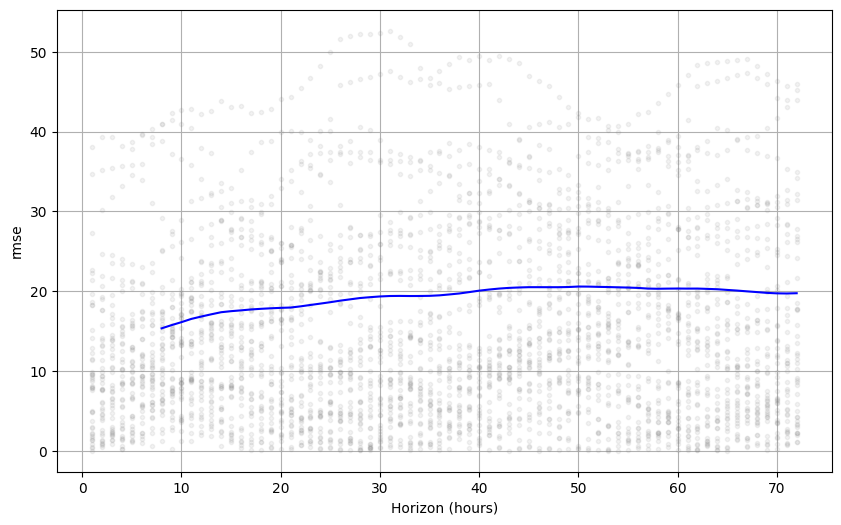

In [17]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Inferencing

# Experimentation
- Each station should have one mlflow run or optuna study name
- Use optuna to search the hyperparameters (create custom function). To test:
    - changepoint_prior_scale - range of [0.001, 0.5]
    - seasonality_prior_scale - range of [0.01, 20]
    - holidays_prior_scale - range of [0.01, 10]
    - seasonality_mode - ['additive', 'multiplicative']
    - forecasting horizon - [12, 24*7], multiplication of 12 - affecting the cv too?
    - add holiday - [true, false]
- Connect to MLflow. To log:
    - figure
        - plot_cross_validation_metric (from cross_validation)
        - inference plot (train+validation and test)

In [18]:
from pprint import pformat
import mlflow
import json

In [73]:
def initiate_mlflow_dagshub(
    secret_json:pathlib.WindowsPath,
    experiment_name:str
):
    with open(secret_json, "r") as f:
        secrets = json.load(f)

    os.environ['MLFLOW_TRACKING_USERNAME'] = secrets['MLFLOW_TRACKING_USERNAME']
    os.environ['MLFLOW_TRACKING_PASSWORD'] = secrets['MLFLOW_TRACKING_PASSWORD']
    os.environ['MLFLOW_TRACKING_URI'] = secrets['MLFLOW_TRACKING_URI']

    # Check if the experiment exists, and if not, create it
    if not mlflow.get_experiment_by_name(experiment_name):
        mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    return secrets, mlflow.get_experiment_by_name(experiment_name).experiment_id

In [74]:
from mlflow.models import infer_signature

In [75]:
# Obtain hyperparameters for this trial
def suggest_hyperparameters(trial):
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 0.01, 20)
    holidays_prior_scale = trial.suggest_float("holidays_prior_scale", 0.01, 10)
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ['additive', 'multiplicative'])
    forecast_horizon = trial.suggest_int("forecast_horizon", 14,24*7,12)
    add_holiday = trial.suggest_categorical("add_holiday", [True, False])
    
    # print(f"Suggested hyperparameters: \n{pformat(trial.params)}")
    return (
        changepoint_prior_scale,
        seasonality_prior_scale,
        holidays_prior_scale,
        seasonality_mode,
        forecast_horizon,
        add_holiday
    )

In [78]:
# turn this into objective function
def objective(trial):
    with mlflow.start_run(experiment_id=experiment_id):
        # params definition
        (
            changepoint_prior_scale,
            seasonality_prior_scale,
            holidays_prior_scale,
            seasonality_mode,
            forecast_horizon,
            add_holiday
        ) = suggest_hyperparameters(trial)
        params = {
            "changepoint_prior_scale": changepoint_prior_scale,
            "seasonality_prior_scale": seasonality_prior_scale,
            "holidays_prior_scale": holidays_prior_scale,
            "seasonality_mode": seasonality_mode,
            "forecast_horizon": forecast_horizon,
            "add_holiday": add_holiday
        }

        # model preparation
        prophet_model = Prophet(
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            seasonality_mode=seasonality_mode
        )
        if add_holiday:
            prophet_model.add_country_holidays(country_name='ID')
        else:
            pass
        prophet_model.fit(data_train)

        # cross validation
        metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
        metrics_raw = cross_validation(
            model=prophet_model,
            horizon=f'{forecast_horizon} hours',
            parallel="processes",
            disable_tqdm=True,
        )
        cv_metrics = performance_metrics(metrics_raw)
        metrics = {f'cv_{k}': cv_metrics[k].mean() for k in metric_keys}

        # prediction
        predictions = prophet_model.predict(data_test.drop(columns=['y']))

        # log model
        MODEL_ARTIFACT_PATH = "model"
        train = prophet_model.history
        signature = infer_signature(train, predictions)
        model_detail = '_'.join(map(str, params.values())[:6])
        mlflow.prophet.log_model(
            prophet_model,
            artifact_path=MODEL_ARTIFACT_PATH,
            signature=signature,
            registered_model_name=f"prophet_{model_detail}"
            )
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)

        # log artifact
        # cv result
        cv_result = plot_cross_validation_metric(metrics_raw, metric='rmse')
        mlflow.log_figure(cv_result, "img/cv_rmse.png")
        # prediction plot
        precidtion_plot, test_rmse = plot_test(
            stasiun_name=used_stasiun,
            train_df=data_train,
            forecast_df=predictions,
            test_df=data_test
        )
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_figure(precidtion_plot, "img/test_rmse.png")
        # model_uri = mlflow.get_artifact_uri(MODEL_ARTIFACT_PATH)
        # print(f"Model artifact logged to: {model_uri}")
    mlflow.end_run()
    return metrics['cv_rmse']

In [57]:
import optuna
# from optuna.integration.mlflow import MLflowCallback

-----------Initiating study for Bekasi Kayuringin station-----------


[I 2023-10-02 14:06:54,056] A new study created in memory with name: no-name-1329e2c9-8d4d-4773-8cd1-a0e5da95b2b6
14:06:54 - cmdstanpy - INFO - Chain [1] start processing
14:06:54 - cmdstanpy - INFO - Chain [1] done processing
Successfully registered model 'prophet_0.1622680957296607_8.271172565699048_7.030578370504278_multiplicative_122_False'.
2023/10/02 14:07:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: prophet_0.1622680957296607_8.271172565699048_7.030578370504278_multiplicative_122_False, version 1
Created version '1' of model 'prophet_0.1622680957296607_8.271172565699048_7.030578370504278_multiplicative_122_False'.
[I 2023-10-02 14:07:12,947] Trial 0 finished with value: 23.514090954122974 and parameters: {'changepoint_prior_scale': 0.1622680957296607, 'seasonality_prior_scale': 8.271172565699048, 'holidays_prior_scale': 7.030578370504278, 'seasonality_mode': 'multiplicative', 'forecast_horizon': 122, 

-----------Initiating study for Bekasi Sukamahi station-----------


[I 2023-10-02 14:07:36,905] A new study created in memory with name: no-name-a93bd7f7-0343-46d7-84c5-fd66e2a6710c
14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:38 - cmdstanpy - INFO - Chain [1] done processing
Successfully registered model 'prophet_0.40988843698448557_1.2672531519650694_8.664719119670023_multiplicative_38_True'.
2023/10/02 14:08:00 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: prophet_0.40988843698448557_1.2672531519650694_8.664719119670023_multiplicative_38_True, version 1
Created version '1' of model 'prophet_0.40988843698448557_1.2672531519650694_8.664719119670023_multiplicative_38_True'.
[I 2023-10-02 14:08:03,092] Trial 0 finished with value: 27.853998968315516 and parameters: {'changepoint_prior_scale': 0.40988843698448557, 'seasonality_prior_scale': 1.2672531519650694, 'holidays_prior_scale': 8.664719119670023, 'seasonality_mode': 'multiplicative', 'forecast_horizon': 38,

-----------Initiating study for Bogor Tanah Sereal station-----------


[I 2023-10-02 14:08:18,052] A new study created in memory with name: no-name-a54a5d14-c855-47b0-8844-216ee79c2a1e
14:08:18 - cmdstanpy - INFO - Chain [1] start processing
14:08:19 - cmdstanpy - INFO - Chain [1] done processing
Successfully registered model 'prophet_0.1563251884930304_9.083327449261102_8.353262735420978_additive_26_True'.
2023/10/02 14:08:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: prophet_0.1563251884930304_9.083327449261102_8.353262735420978_additive_26_True, version 1
Created version '1' of model 'prophet_0.1563251884930304_9.083327449261102_8.353262735420978_additive_26_True'.
[I 2023-10-02 14:08:47,446] Trial 0 finished with value: 22.717245448912383 and parameters: {'changepoint_prior_scale': 0.1563251884930304, 'seasonality_prior_scale': 9.083327449261102, 'holidays_prior_scale': 8.353262735420978, 'seasonality_mode': 'additive', 'forecast_horizon': 26, 'add_holiday': True}. Best is t

-----------Initiating study for Depok Pancoran Mas station-----------


[I 2023-10-02 14:09:06,801] A new study created in memory with name: no-name-60572d01-8338-422a-b593-9b2c49f69629
14:09:07 - cmdstanpy - INFO - Chain [1] start processing
14:09:08 - cmdstanpy - INFO - Chain [1] done processing
Successfully registered model 'prophet_0.4490251179344137_7.0978790764555795_4.036293299806922_additive_50_False'.
2023/10/02 14:09:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: prophet_0.4490251179344137_7.0978790764555795_4.036293299806922_additive_50_False, version 1
Created version '1' of model 'prophet_0.4490251179344137_7.0978790764555795_4.036293299806922_additive_50_False'.
[I 2023-10-02 14:09:23,816] Trial 0 finished with value: 18.57268165868089 and parameters: {'changepoint_prior_scale': 0.4490251179344137, 'seasonality_prior_scale': 7.0978790764555795, 'holidays_prior_scale': 4.036293299806922, 'seasonality_mode': 'additive', 'forecast_horizon': 50, 'add_holiday': False}. Be

-----------Initiating study for Karawang Wetan station-----------


[I 2023-10-02 14:09:55,315] A new study created in memory with name: no-name-b50c36cb-207b-4646-b7e0-e8b4e2f2c5d4
14:09:55 - cmdstanpy - INFO - Chain [1] start processing
14:09:56 - cmdstanpy - INFO - Chain [1] done processing
Successfully registered model 'prophet_0.07417605028612743_12.866110578658185_0.7715191758755688_multiplicative_110_False'.
2023/10/02 14:10:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: prophet_0.07417605028612743_12.866110578658185_0.7715191758755688_multiplicative_110_False, version 1
Created version '1' of model 'prophet_0.07417605028612743_12.866110578658185_0.7715191758755688_multiplicative_110_False'.
[I 2023-10-02 14:10:06,833] Trial 0 finished with value: 36.337217575863946 and parameters: {'changepoint_prior_scale': 0.07417605028612743, 'seasonality_prior_scale': 12.866110578658185, 'holidays_prior_scale': 0.7715191758755688, 'seasonality_mode': 'multiplicative', 'forecast_hor

-----------Initiating study for Tangerang Pasir Jaya station-----------


[I 2023-10-02 14:10:20,794] A new study created in memory with name: no-name-e396b3c5-e5f5-4b11-899e-b0d1b8c346ef
14:10:21 - cmdstanpy - INFO - Chain [1] start processing
14:10:21 - cmdstanpy - INFO - Chain [1] done processing
Successfully registered model 'prophet_0.017016770386622308_17.789464280737842_8.070990035830173_additive_158_False'.
2023/10/02 14:10:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: prophet_0.017016770386622308_17.789464280737842_8.070990035830173_additive_158_False, version 1
Created version '1' of model 'prophet_0.017016770386622308_17.789464280737842_8.070990035830173_additive_158_False'.
[I 2023-10-02 14:10:49,208] Trial 0 finished with value: 33.15631154390407 and parameters: {'changepoint_prior_scale': 0.017016770386622308, 'seasonality_prior_scale': 17.789464280737842, 'holidays_prior_scale': 8.070990035830173, 'seasonality_mode': 'additive', 'forecast_horizon': 158, 'add_holiday'

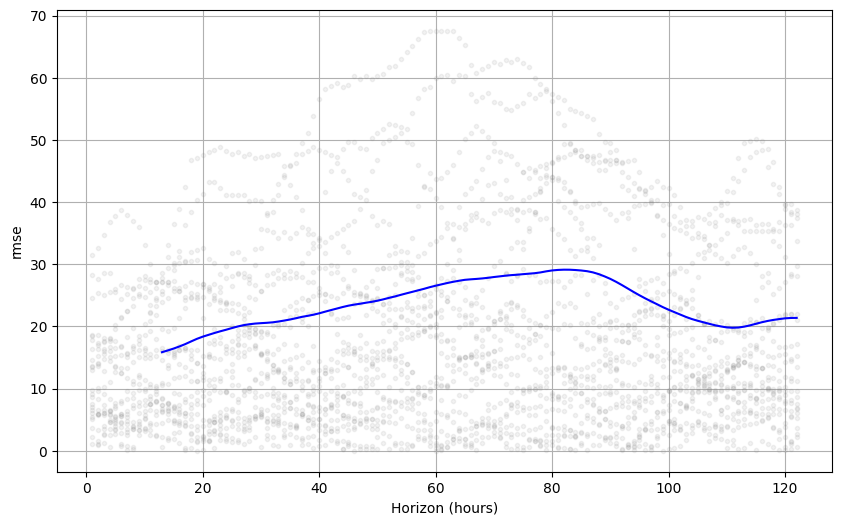

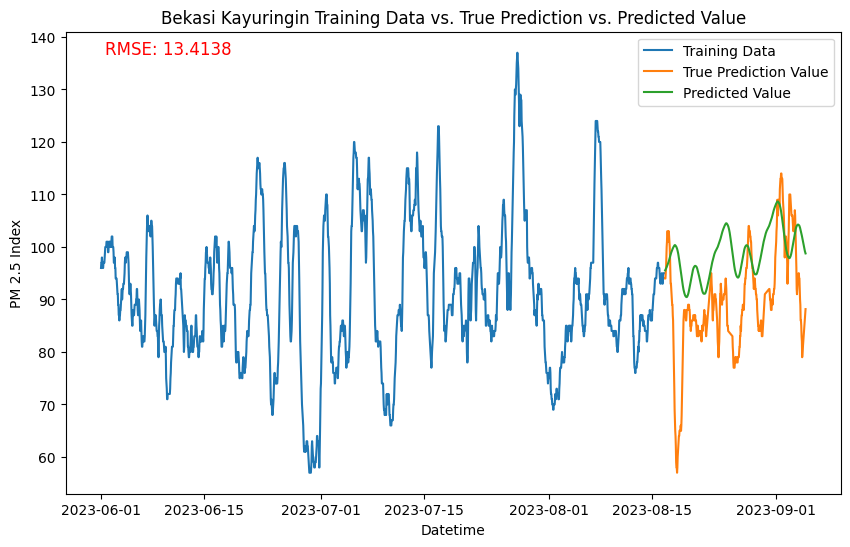

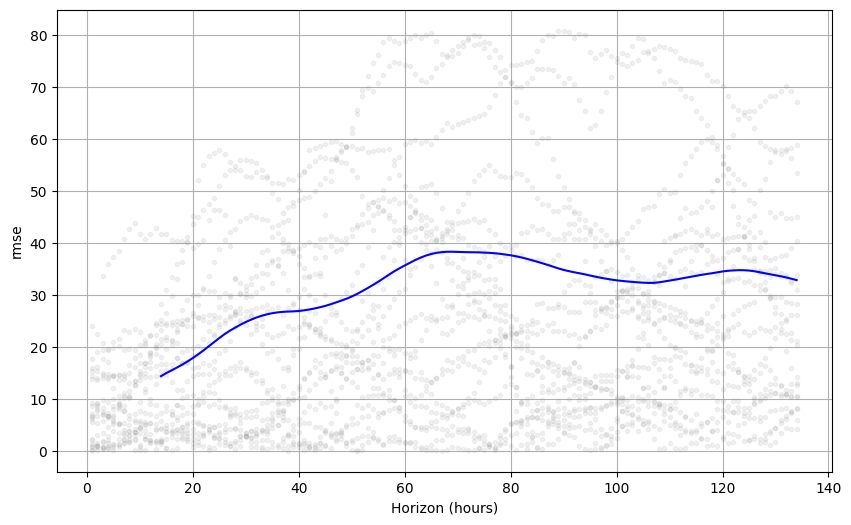

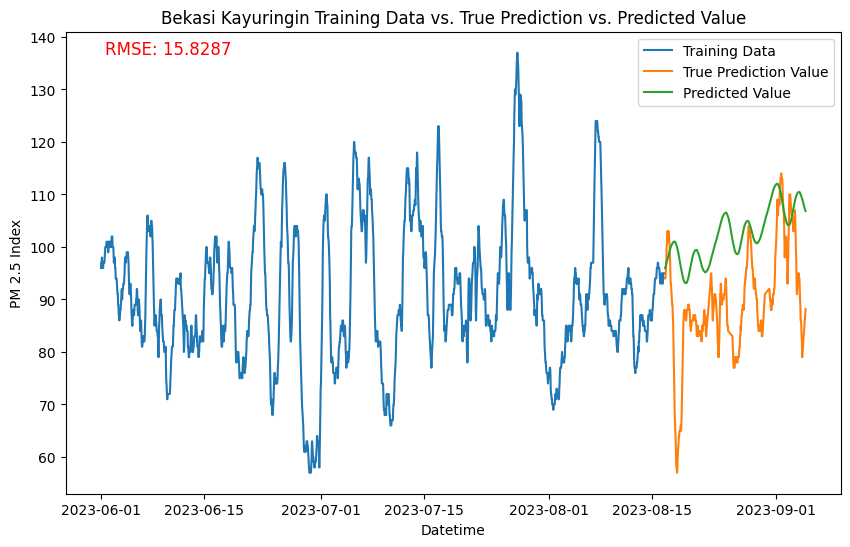

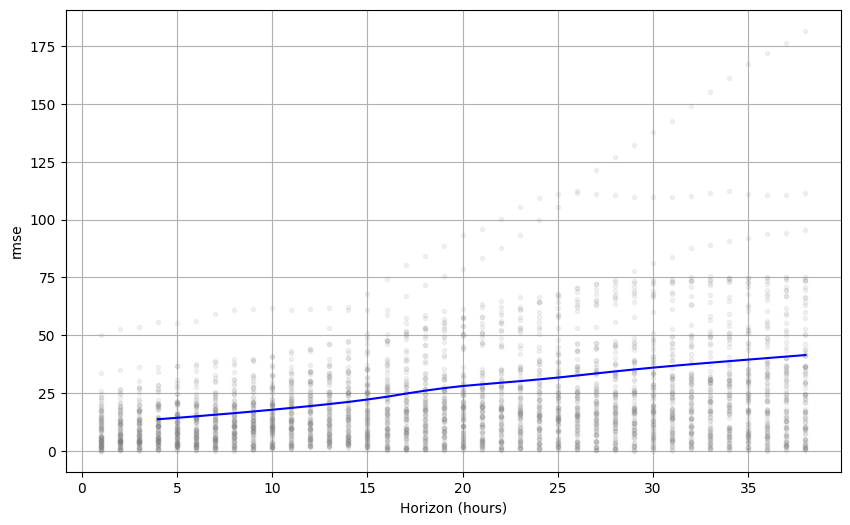

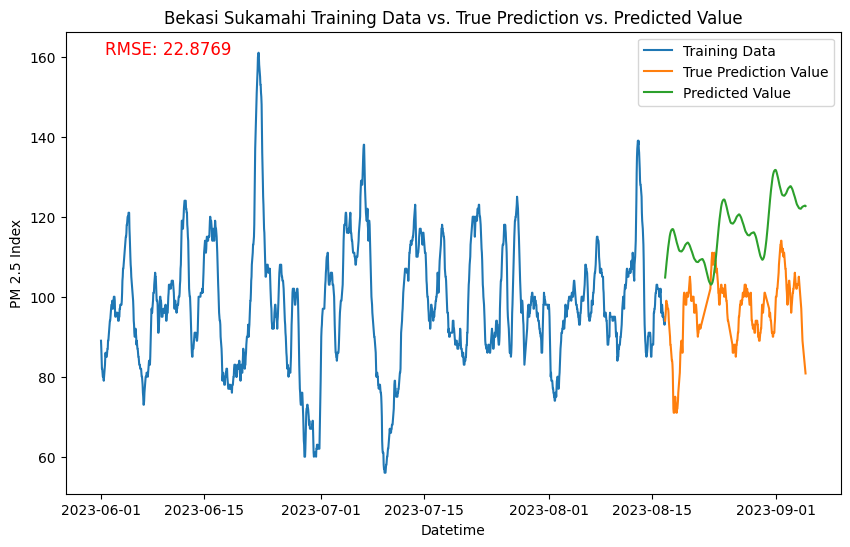

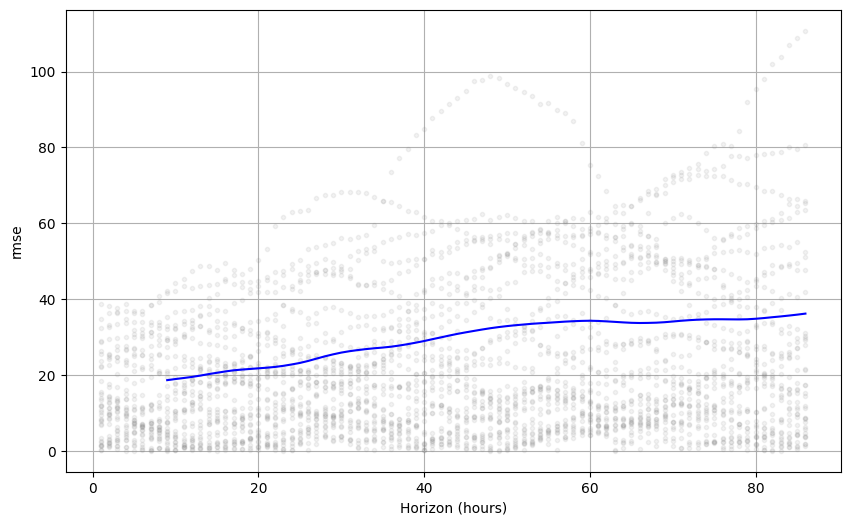

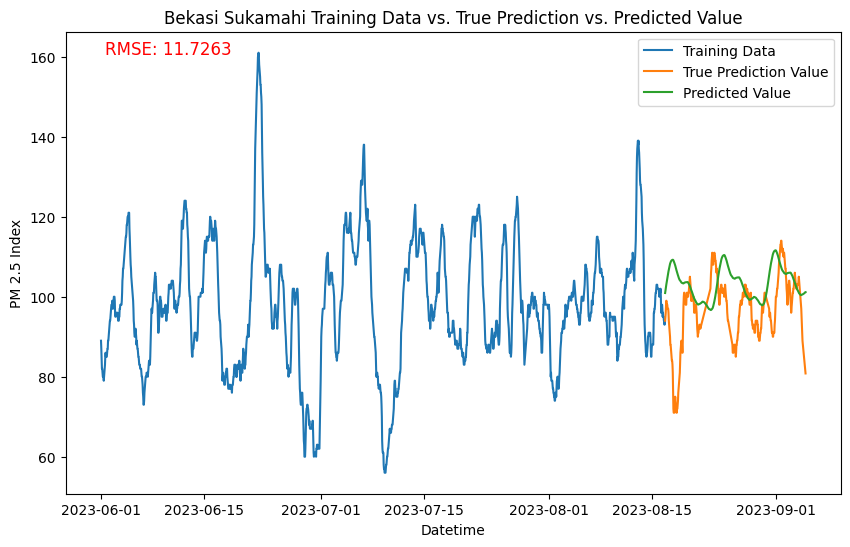

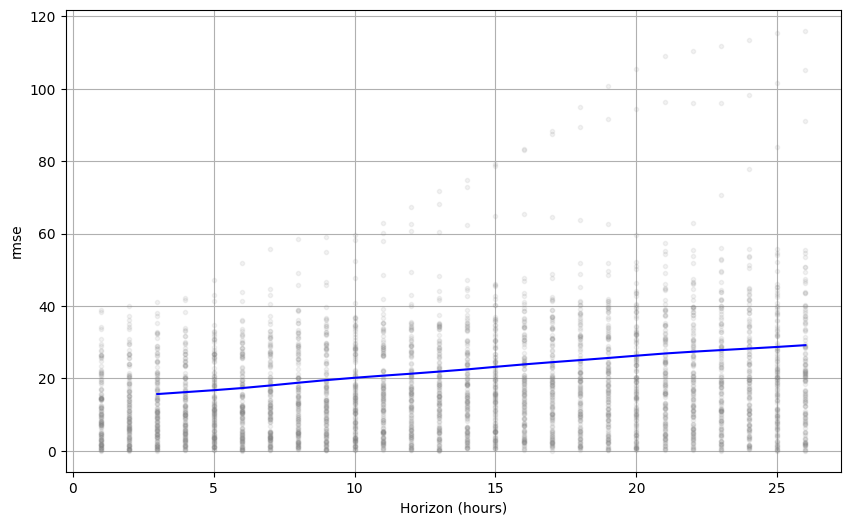

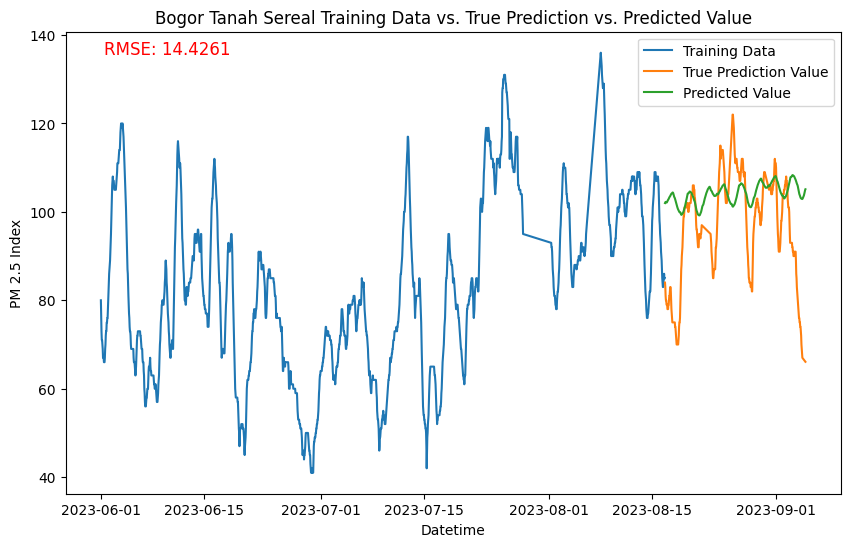

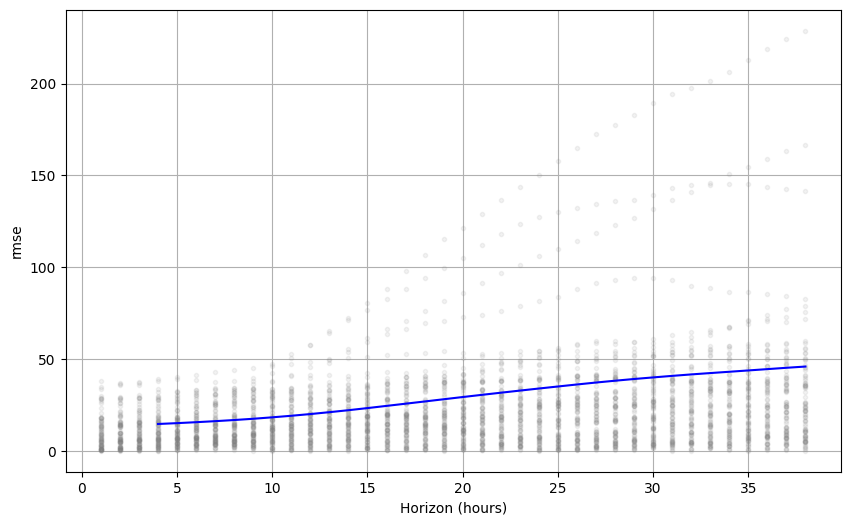

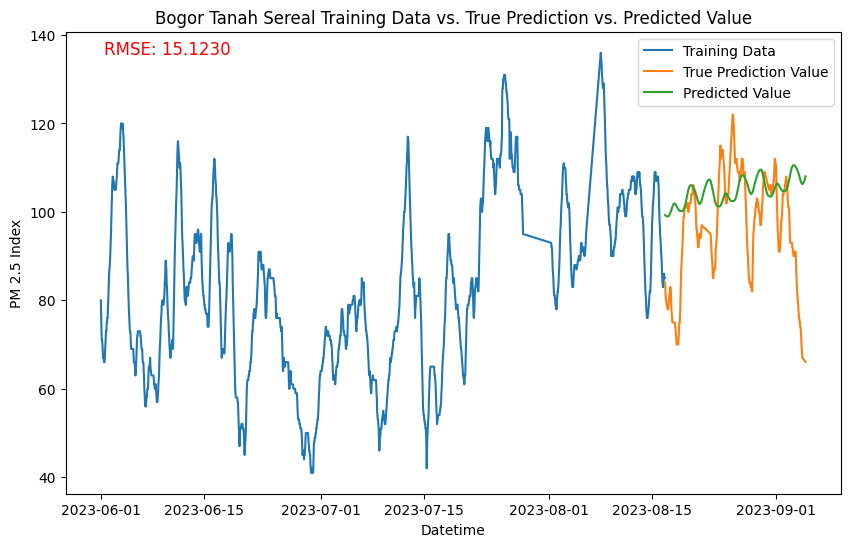

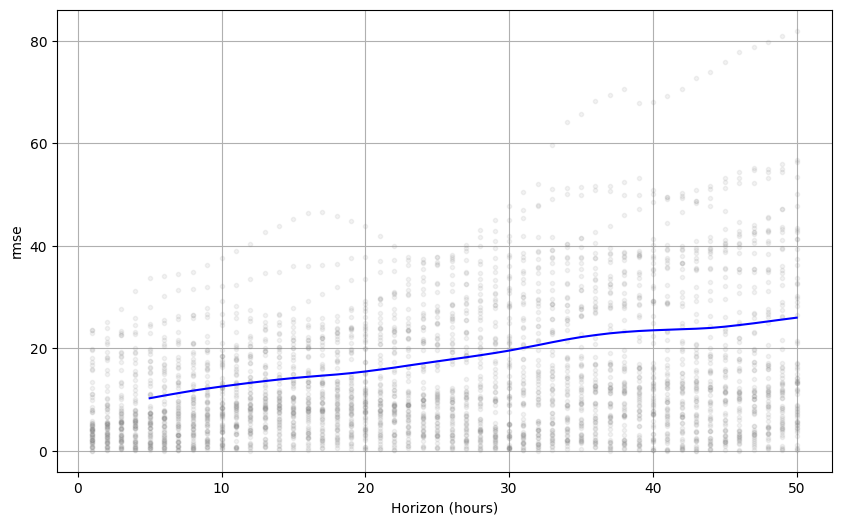

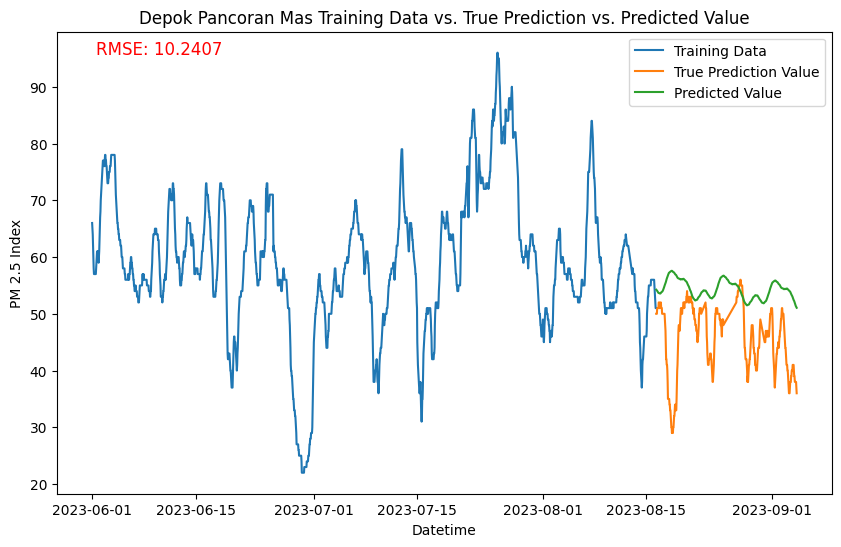

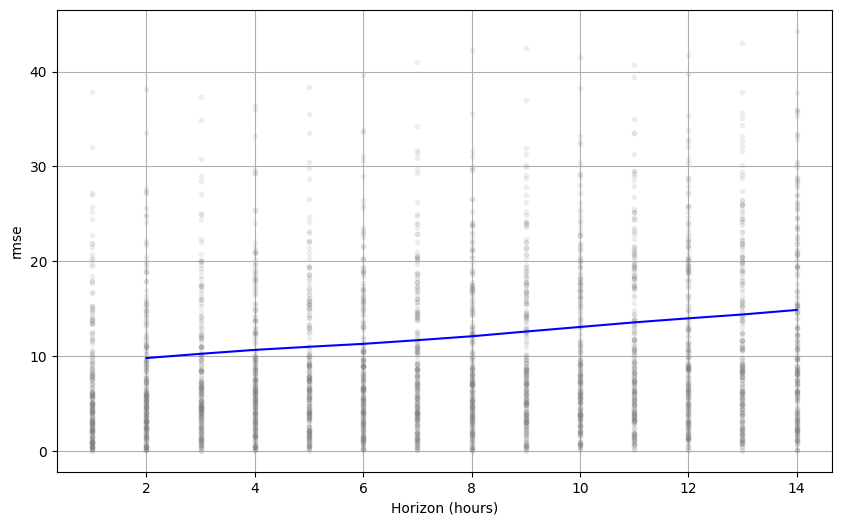

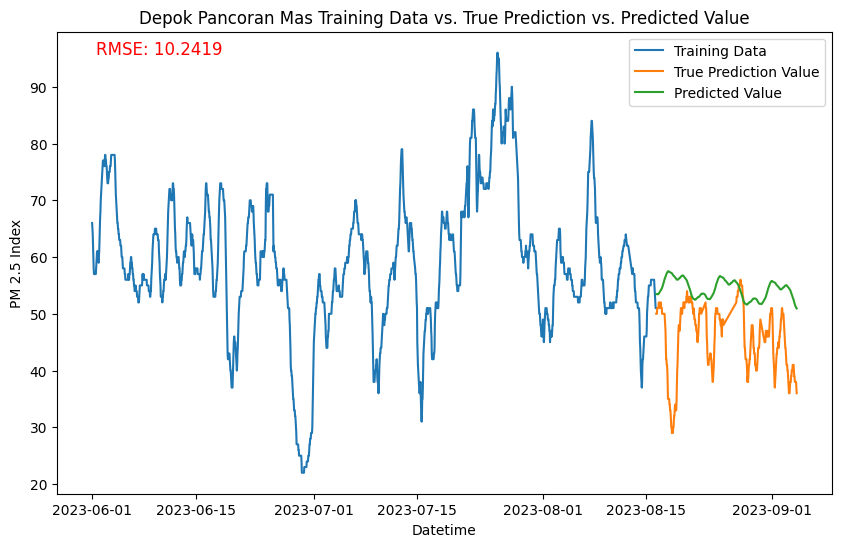

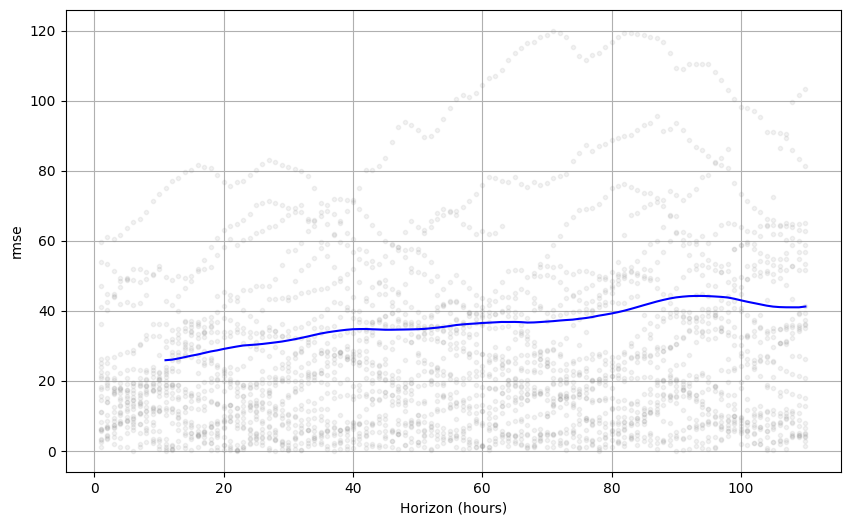

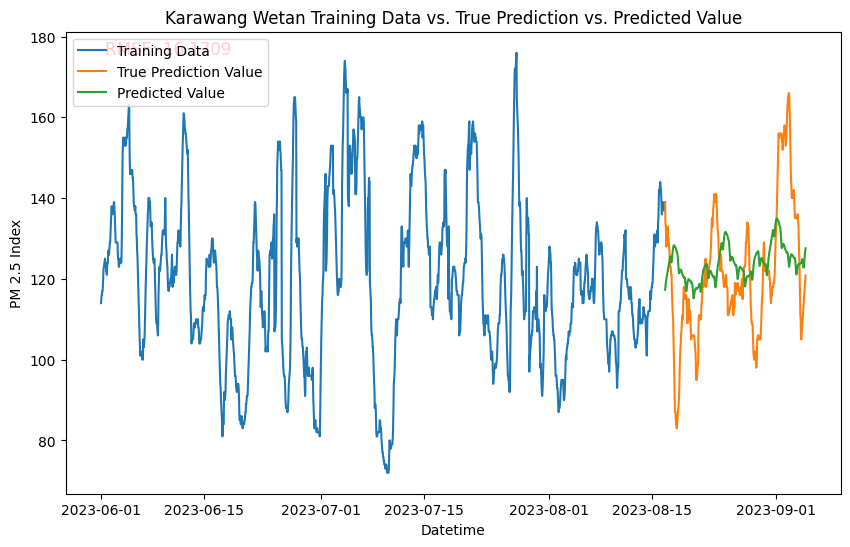

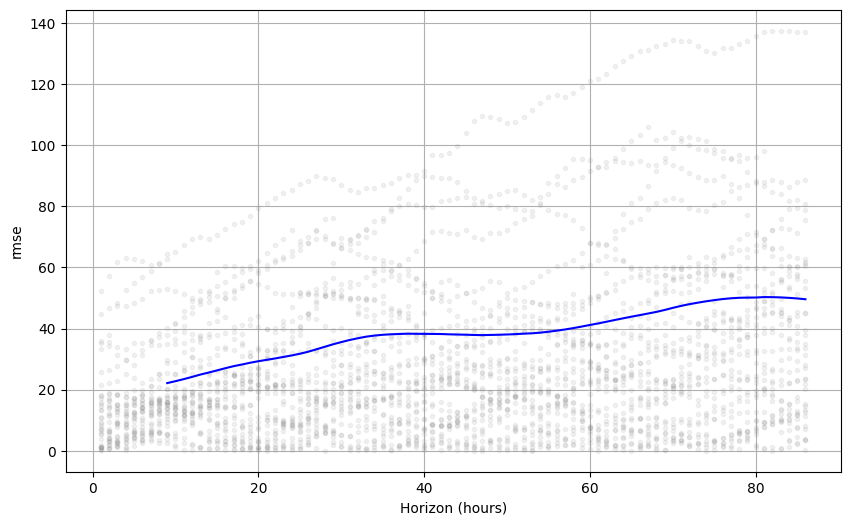

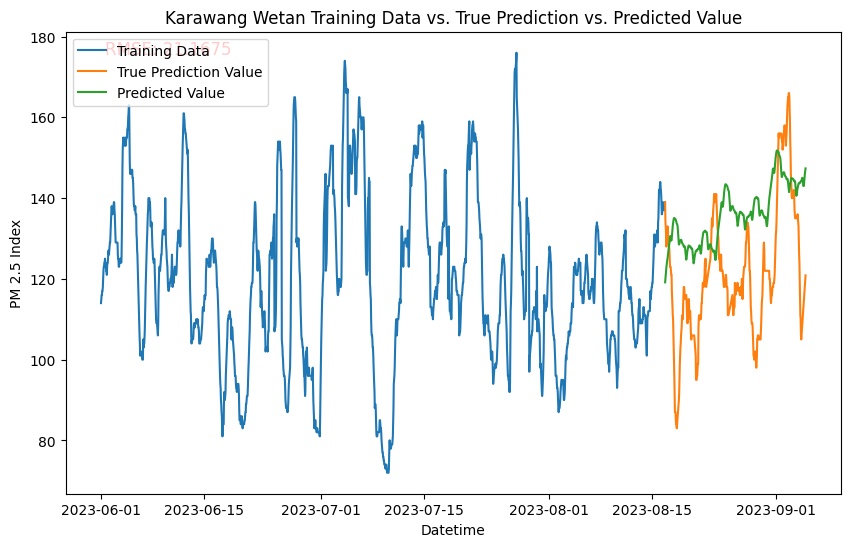

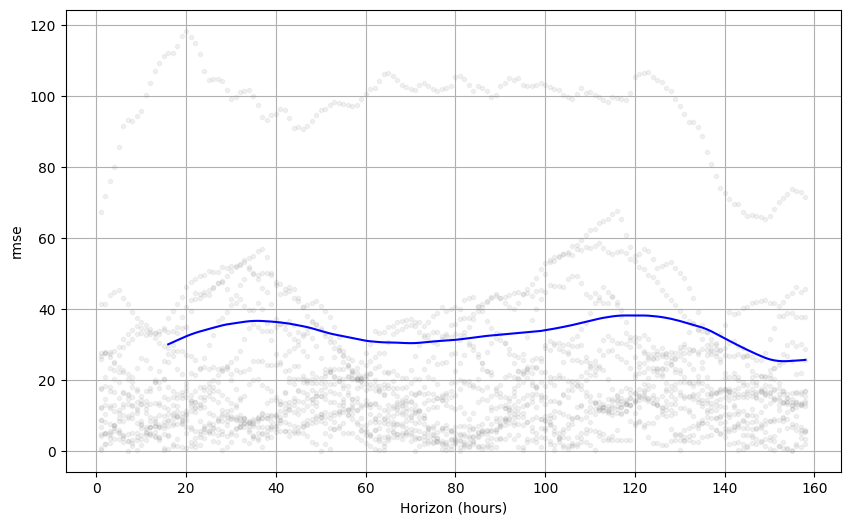

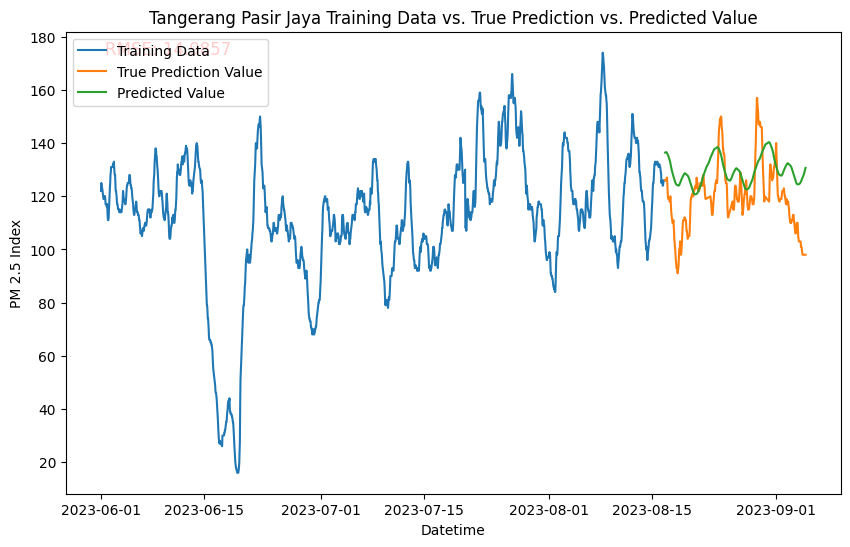

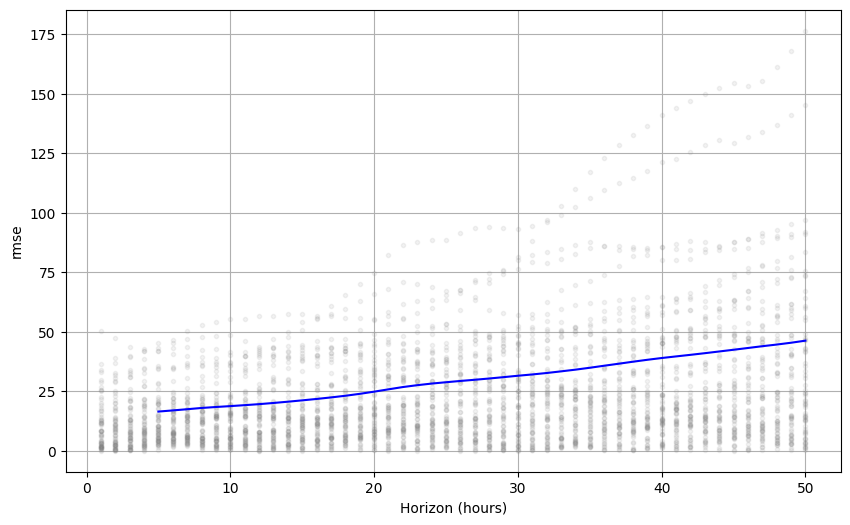

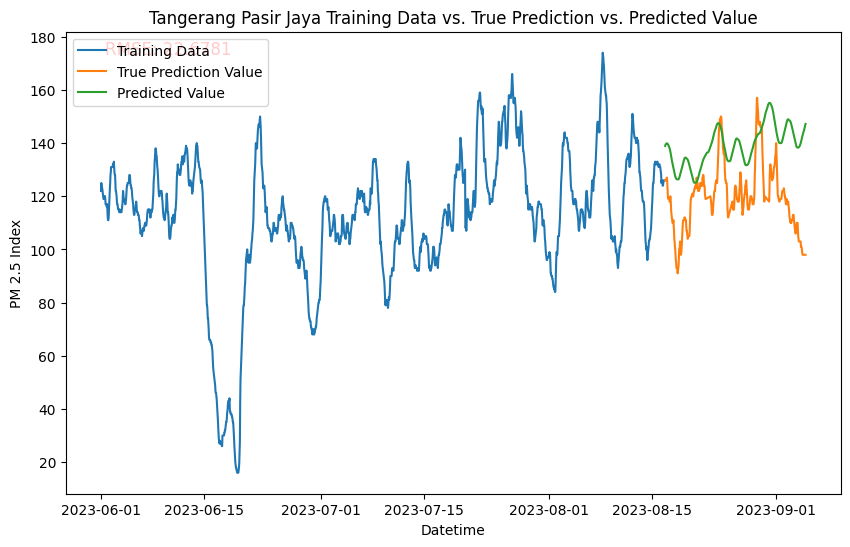

In [79]:
for used_stasiun in processed_data['stasiun'].unique():
    print(f"\n-----------Initiating study for {used_stasiun} station-----------")
    data_train = isolate_stasiun(train_df, used_stasiun)
    data_test = isolate_stasiun(test_df, used_stasiun)

    experiment_name = f"{used_stasiun}_prophet_test"
    secrets, experiment_id = initiate_mlflow_dagshub(secret_dir/"mlflow_dagshub.json", experiment_name)

    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(pruner=pruner, direction="minimize")
    study.optimize(
        objective,
        n_trials=2,
        )

In [81]:
client = mlflow.tracking.MlflowClient(tracking_uri=secrets["MLFLOW_TRACKING_URI"])
runs = client.search_runs(experiment_id, "", order_by=["metrics.test_rmse DESC"], max_results=1)
best_run = runs[0]

In [90]:
clean_model_name = '_'.join(map(str, best_run.data.params.values()))
clean_model_name = "prophet_"+clean_model_name
clean_model_name

'prophet_0.26762061816561206_3.1646927903446853_7.4595853023566505_multiplicative_50_True'

In [91]:
model_uri = f"models:/{clean_model_name}/latest"
loaded_model = mlflow.prophet.load_model(model_uri)

In [ ]:
predictions = loaded_model.predict(data_test.drop(columns=['y']))